# Mountain cart

This is the notebook for the implement the mountain cart problem. 
It is divided into:
1. Random Agent
2. DQN approach
3. Dyna approach

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

# **1.** Random Agent

In [44]:
from RandomAgent import RandomAgent

env = gym.make('MountainCar-v0')#, render_mode = "human")
agent = RandomAgent(env)
num_episodes = 100

rewards = []
for episode in tqdm(range(num_episodes)):
    seed = np.random.randint(0, 100000)
    state = env.reset(seed=seed)
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)
        agent.observe(state, action, next_state, reward)
        agent.update()
        total_reward += reward
        state = next_state

    rewards.append(total_reward)

  4%|▍         | 4/100 [00:01<00:33,  2.90it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'Episode number')

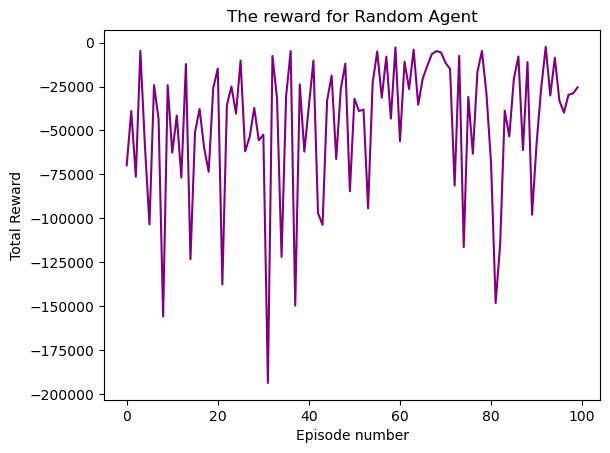

In [34]:
fig, ax = plt.subplots()
ax.plot(rewards, color = "purple")
ax.set_title("The reward for Random Agent")
ax.set_ylabel("Total Reward")
ax.set_xlabel("Episode number")

In [35]:
n_episodes=100
durations=[]
for i in tqdm(range(n_episodes)):
    t0 = time()
    done = False
    seed = np.random.randint(0, 100000)
    state, info = env.reset(seed=seed), None
    episode_reward = 0
    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)

        episode_reward += reward

        state = next_state
        done = terminated or truncated
    t1=time()
    durations.append(t1-t0)

100%|██████████| 100/100 [00:00<00:00, 684.57it/s]


Text(0.5, 1.0, 'Duration of episodes')

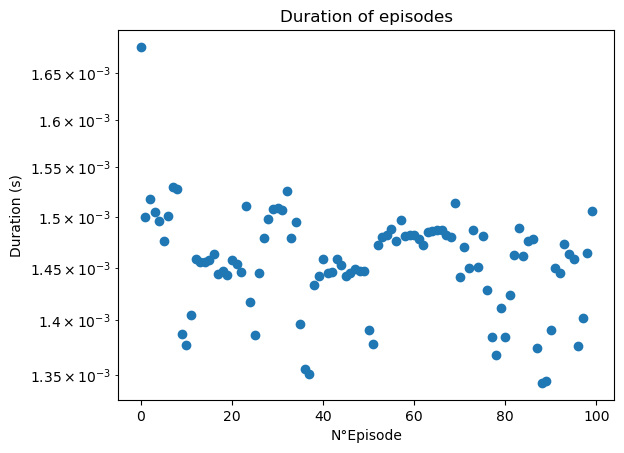

In [36]:
plt.scatter(range(n_episodes),durations)
plt.yscale('log')
plt.xlabel('N°Episode')
plt.ylabel('Duration (s)')
plt.title('Duration of episodes')

# **2.** DQN Agent

In [7]:
from DQN import DQNAgent, DQNnetwork

num_episodes = 1000
env = gym.make('MountainCar-v0') #, render_mode = "human"
state_size, action_size = env.observation_space.shape[0], env.action_space.n
agent = DQNAgent(env, state_size, action_size)
rewards, durations,dones = agent.train(env, agent, num_episodes)
agent.save_agent(f"DQN_{num_episodes}_episodes")

100%|██████████| 1000/1000 [01:37<00:00, 10.27it/s]

Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes/


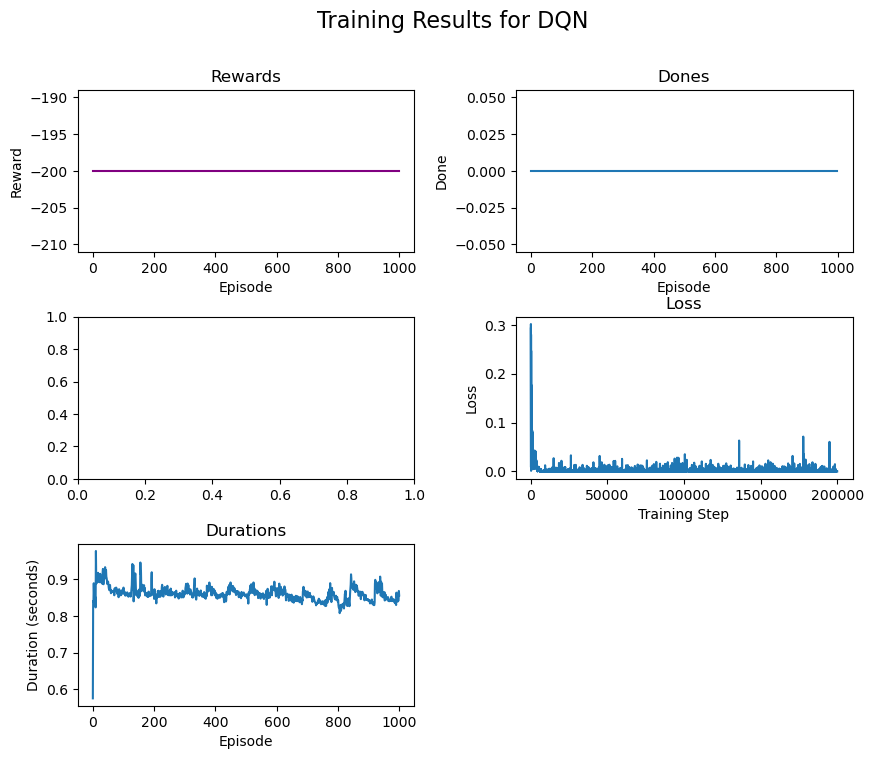

In [ ]:
agent.plots()

# **2.1** Modified Reward function of the DQN environment

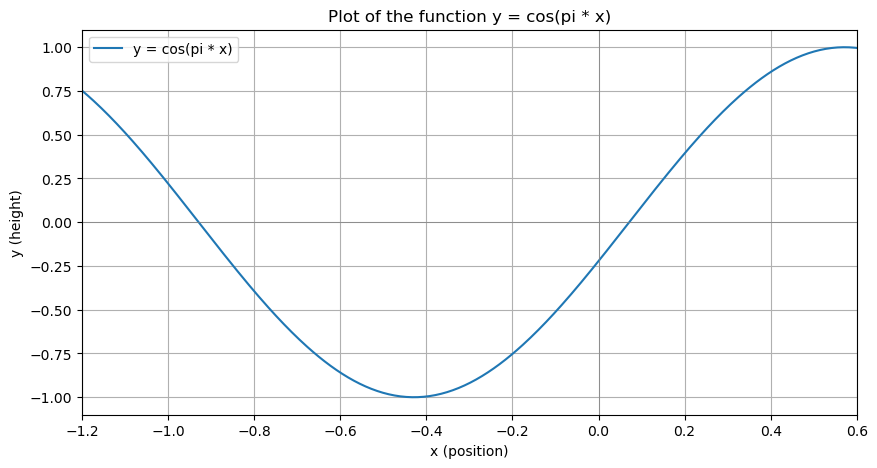

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(-1.2, 0.6, 400)
# Compute y values for cos(pi * x)
y = np.cos(np.pi * x - np.pi/1.5 + 0.3)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='y = cos(pi * x)')
plt.xlim(-1.2, 0.6)
plt.title('Plot of the function y = cos(pi * x)')
plt.xlabel('x (position)')
plt.ylabel('y (height)')
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.grid(True)
plt.legend()
plt.show()


In [13]:
import numpy as np

def calculate_reward(position, done, step_penalty=10, C=100, D=50):
    goal_position = 0.5   # position of the goal
    min_position = -1.2   # leftmost position
    
    # Normalize the position to be between 0 and 1, where 1 is the goal
    norm_position = (position - min_position) / (goal_position - min_position)

    # Calculate the position-based reward component (proximity to goal)
    position_reward = -C * (1 - norm_position)  # Less negative as it approaches the goal
    
    # Calculate the height-based reward component
    height = np.cos(np.pi * position - np.pi/1.5 + 0.3)
    height_reward = -D * (1 - height)  # Less negative as the cart climbs higher
    
    # Total reward combines position reward, height reward, and a time penalty
    total_reward = position_reward + height_reward
    if not done:
        total_reward -= step_penalty

    return total_reward


In [16]:
import gym
import math
import numpy as np
from typing import Optional

# modify the environment class by inheriting the gymnasium environment class of the mountain cart, and changing the step() function such that the reward is always 1
class MountainCarReward1(gym.Env):
    def __init__(self, C=100, D=50, step_penalty = 10, aux_factor = 1, render_mode: Optional[str] = None):
        self.render_mode = render_mode
        self.env = gym.make('MountainCar-v0', render_mode=render_mode)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.reward_range = self.env.reward_range
        self.number_steps = 0
        self.C = C
        self.D = D
        self.step_penalty = step_penalty
        self.aux_factor = aux_factor

    def step(self, action: int, reward_function="-1"):
        assert self.action_space.contains(action), f"{action!r} ({type(action)}) invalid"
        state, reward, done, truncated, _ = self.env.step(action)
        self.number_steps += 1
        
        if reward_function == "euclidean":
            aux_reward = 100 if done else np.sqrt(np.abs(state[0] - (-0.5))**2)
        elif reward_function == "complex": 
            aux_reward = calculate_reward(state[0], done, step_penalty=self.step_penalty, C=self.C, D=self.D)
        else:
            aux_reward = 0

        if self.number_steps == 200:
            truncated = True

        final_reward = reward + aux_reward * self.aux_factor
        self.reward = reward
        self.aux_reward = aux_reward
        self.final_reward = final_reward

        return np.array(state, dtype=np.float32), final_reward, done, truncated, {}
    
    def get_decomposed_rewards(self):
        return self.reward, self.aux_reward, self.final_reward

    def reset(self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
        ):
        self.number_steps = 0
        return self.env.reset(seed=seed, options=options)

    def render(self, render_mode='human'):
        return self.env.render(render_mode=render_mode)

    def close(self):
        return self.env.close()

In this case we have a 100 times bigger auxiliary reward function. This is done to make the agent learn faster.<br>
We will try to change these parameters

In [17]:
from DQN import DQNAgent

num_episodes = 3000
reward_function = "complex"

env = MountainCarReward1(render_mode=None, C = 100, D = 50, step_penalty=30, aux_factor = 0.05)
state_size, action_size = env.observation_space.shape[0], env.action_space.n
agent = DQNAgent(env, state_size, action_size,target_update_frequency = 10000)
agent.train(env, agent, num_episodes, reward_function=reward_function)
agent.save_agent(f"DQN_{num_episodes}_episodes_{reward_function}")

# PLOTS
agent.load_agent(f"DQN_{num_episodes}_episodes_{reward_function}")
agent.plots(reward_function=reward_function)
agent.reward_plot(reward_function=reward_function)
agent.dones_plots(reward_function=reward_function)

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/silviaromanato/anaconda3/envs/arm64env/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 3000/3000 [05:42<00:00,  8.76it/s]

Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_complex/


let's try with a small auxiliary reward function, 10 times smaller

In [ ]:
from DQN import DQNAgent

num_episodes = 3000
reward_function = "complex"

env = MountainCarReward1(render_mode=None, C = 100, D = 50, step_penalty=30, aux_factor = 0.005)
state_size, action_size = env.observation_space.shape[0], env.action_space.n
agent = DQNAgent(env, state_size, action_size,target_update_frequency = 10000)
agent.train(env, agent, num_episodes, reward_function=reward_function)
agent.save_agent(f"DQN_{num_episodes}_episodes_{reward_function}")

# PLOTS
agent.load_agent(f"DQN_{num_episodes}_episodes_{reward_function}")
agent.plots(reward_function=reward_function)
agent.reward_plot(reward_function=reward_function)
agent.dones_plots(reward_function=reward_function)

let's try with a bigger one, 10 times bigger

In [ ]:
from DQN import DQNAgent

num_episodes = 3000
reward_function = "complex"

env = MountainCarReward1(render_mode=None, C = 100, D = 50, step_penalty=30, aux_factor = 0.5)
state_size, action_size = env.observation_space.shape[0], env.action_space.n
agent = DQNAgent(env, state_size, action_size,target_update_frequency = 10000)
agent.train(env, agent, num_episodes, reward_function=reward_function)
agent.save_agent(f"DQN_{num_episodes}_episodes_{reward_function}")

# PLOTS
agent.load_agent(f"DQN_{num_episodes}_episodes_{reward_function}")
agent.plots(reward_function=reward_function)
agent.reward_plot(reward_function=reward_function)
agent.dones_plots(reward_function=reward_function)

does the agent successfully solve the task? In less than 1000 episodes?

# **3.4** DQN with RND

this is with a reward factor of 100, let's try with small and big ones.

100%|██████████| 3000/3000 [08:49<00:00,  5.67it/s]


Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_rnd/


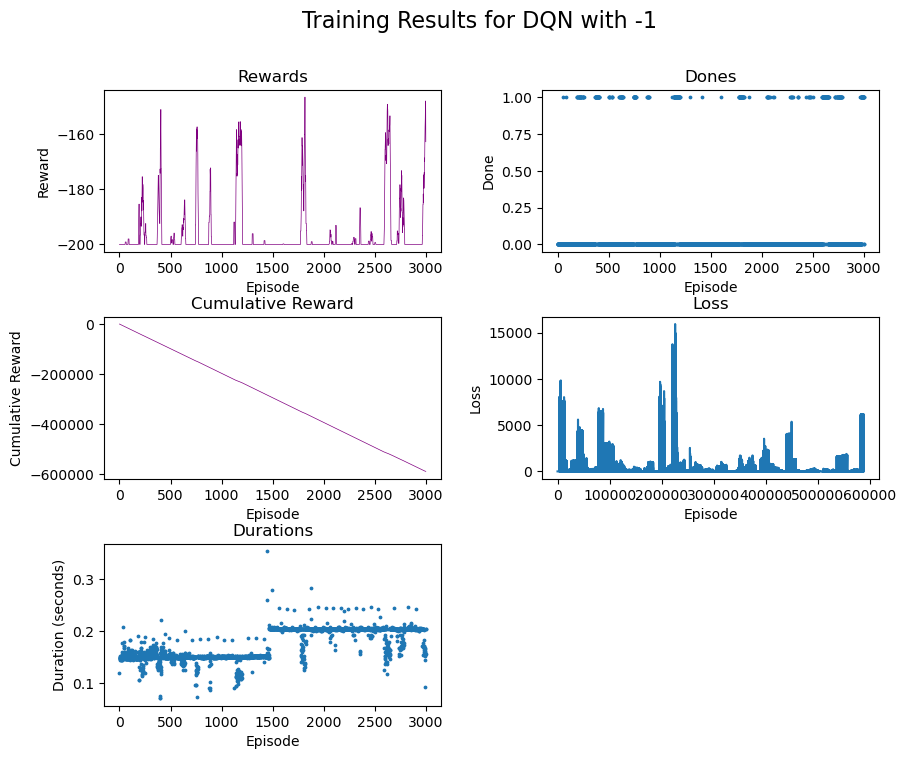

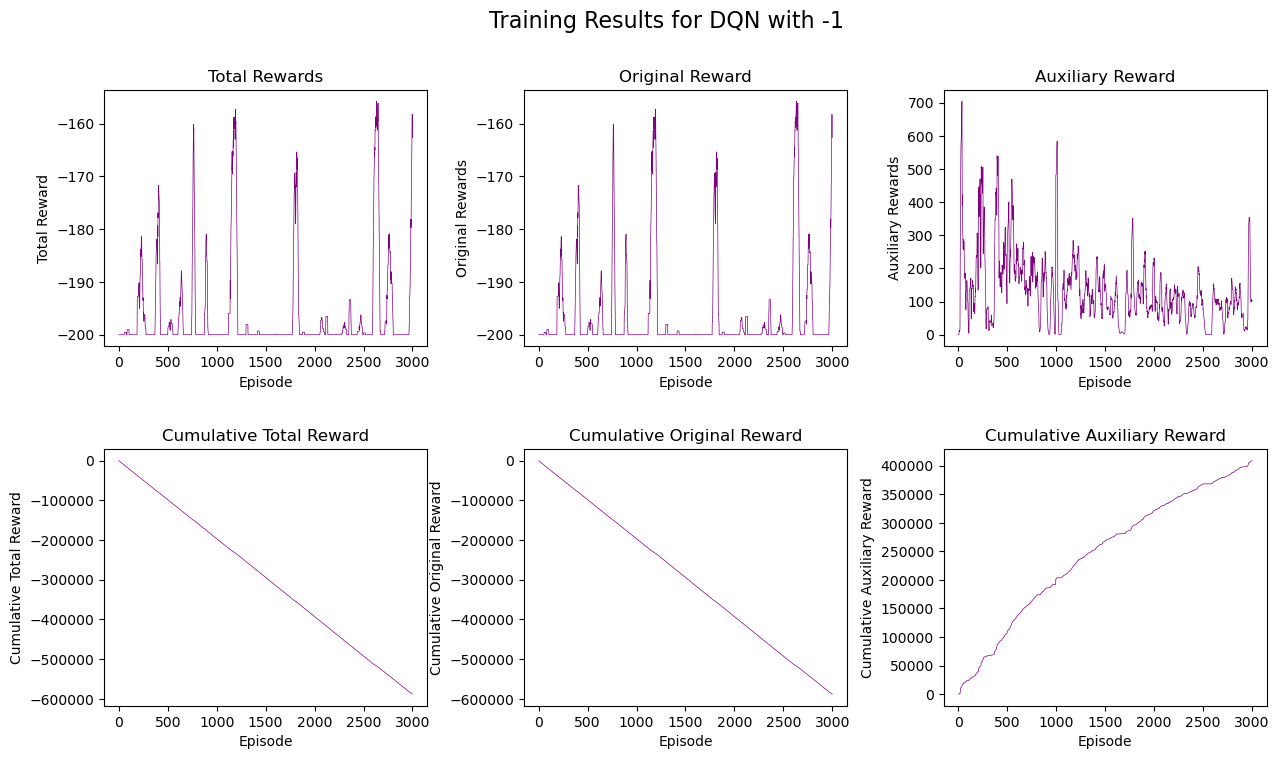

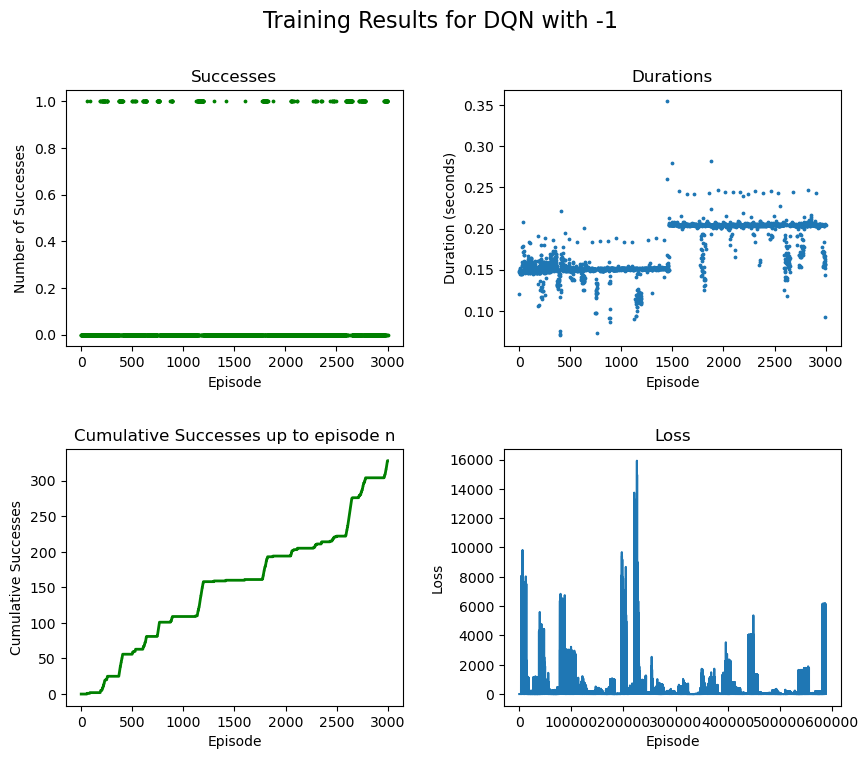

In [43]:
import gymnasium as gym
from DQN import *

# Define your environment here
env = gym.make("MountainCar-v0")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
num_episodes = 3000
reward_function = "-1"

agent = DQNAgent(
    env=env,
    state_size=state_size,
    action_size=action_size,
    gamma=0.99,
    min_epsilon=0.05,
    max_epsilon=0.9,
    decay_epsilon=0.995,
    replay_buffer_max=10000,
    batch_size=64,
    learning_rate=0.001,
    hidden_layer_sizes=[64, 64],
    target_update_frequency=500,
    reward_factor=
)

# Training the agent
rewards = agent.train(env, agent, num_episodes=num_episodes, rnd = True)
agent.save_agent(f"DQN_{num_episodes}_episodes_rnd")
agent.plots()
agent.reward_plot()
agent.dones_plots()


small reward factor

100%|██████████| 3000/3000 [07:38<00:00,  6.55it/s]


Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_rnd/


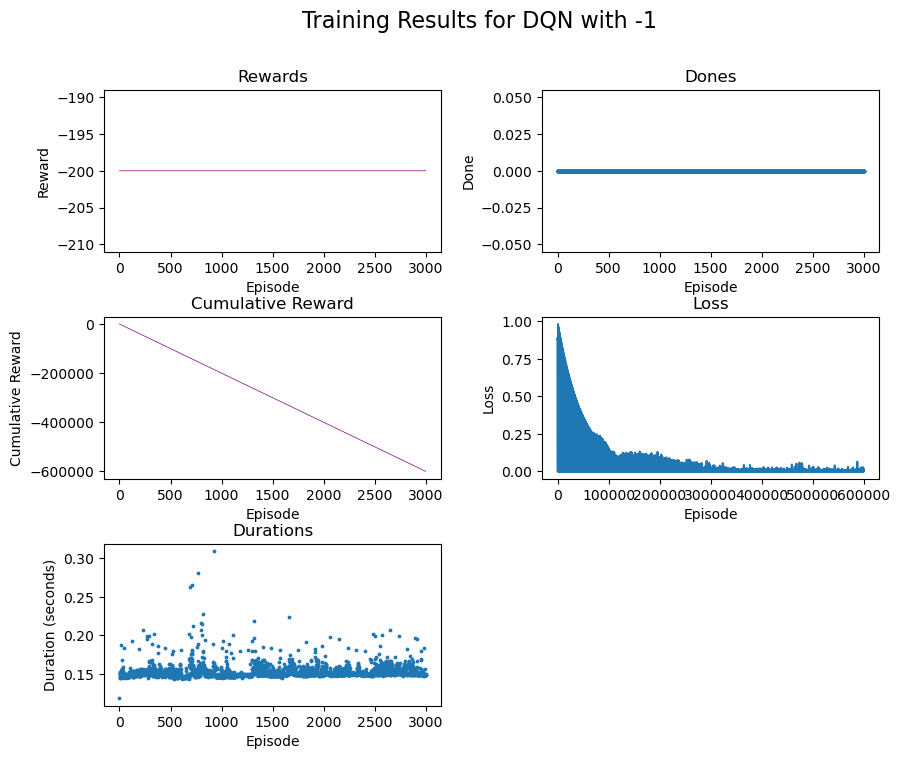

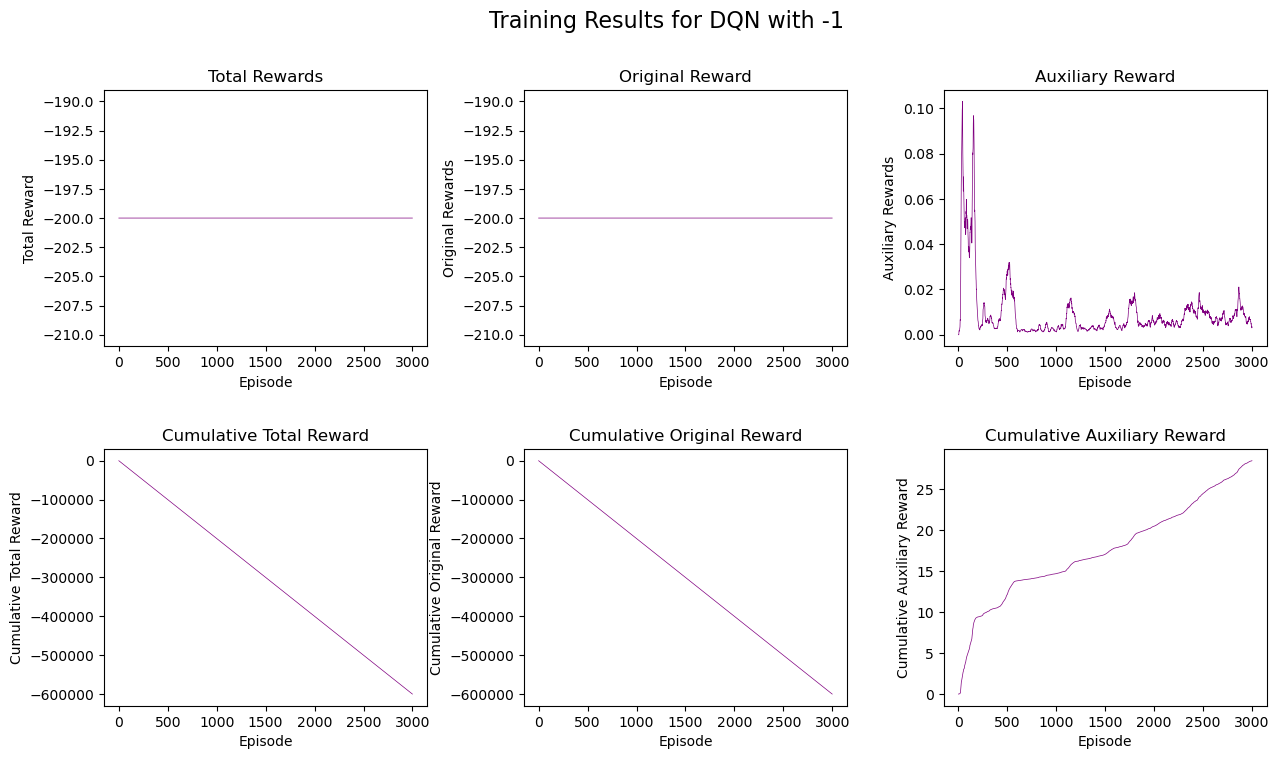

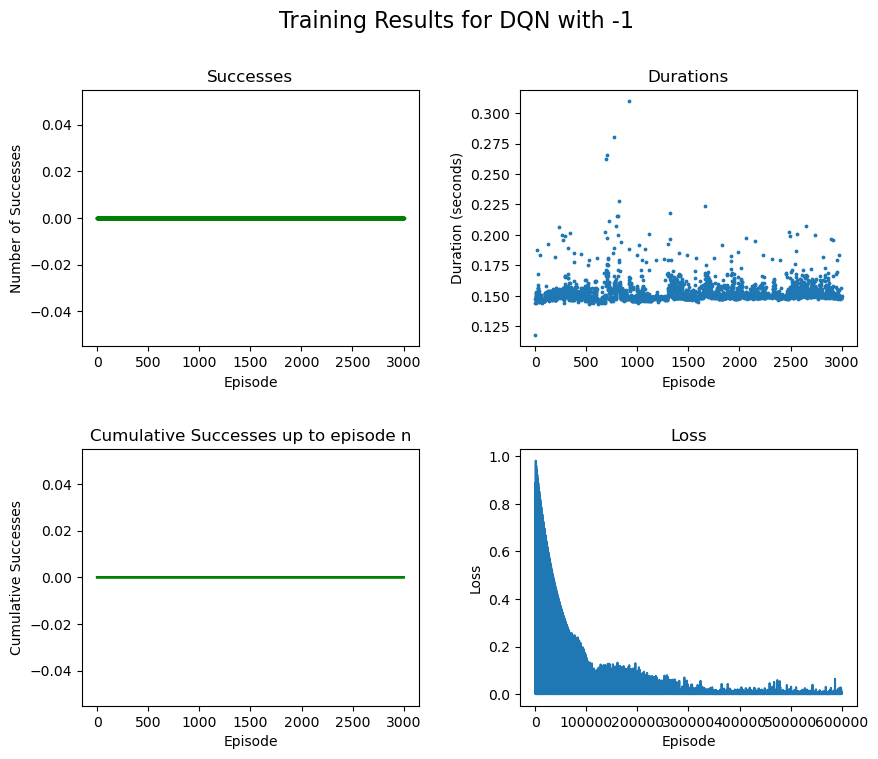

In [47]:
import gymnasium as gym
from DQN import *

# Define your environment here
env = gym.make("MountainCar-v0")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
num_episodes = 3000

agent = DQNAgent(
    env=env,
    state_size=state_size,
    action_size=action_size,
    gamma=0.99,
    min_epsilon=0.05,
    max_epsilon=0.9,
    decay_epsilon=0.995,
    replay_buffer_max=10000,
    batch_size=64,
    learning_rate=0.001,
    hidden_layer_sizes=[64, 64],
    target_update_frequency=1000,
    reward_factor=10
)

# Training the agent
rewards = agent.train(env, agent, num_episodes=num_episodes, rnd = True)
agent.save_agent(f"DQN_{num_episodes}_episodes_rnd")
agent.plots()
agent.reward_plot()
agent.dones_plots()

medium reward factor

100%|██████████| 3000/3000 [08:11<00:00,  6.10it/s]


Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_rnd/


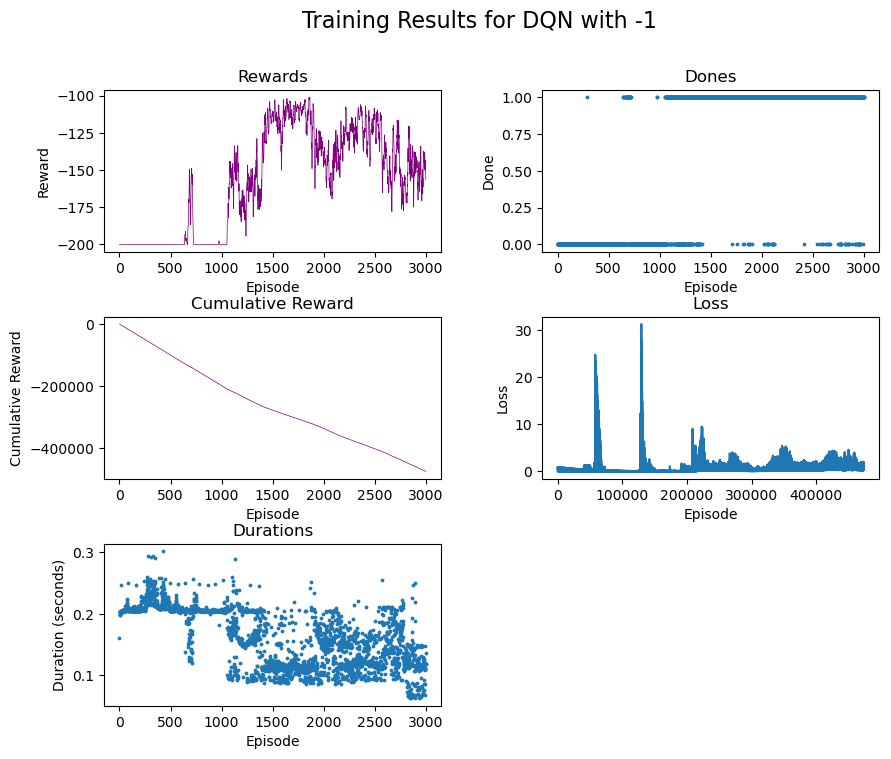

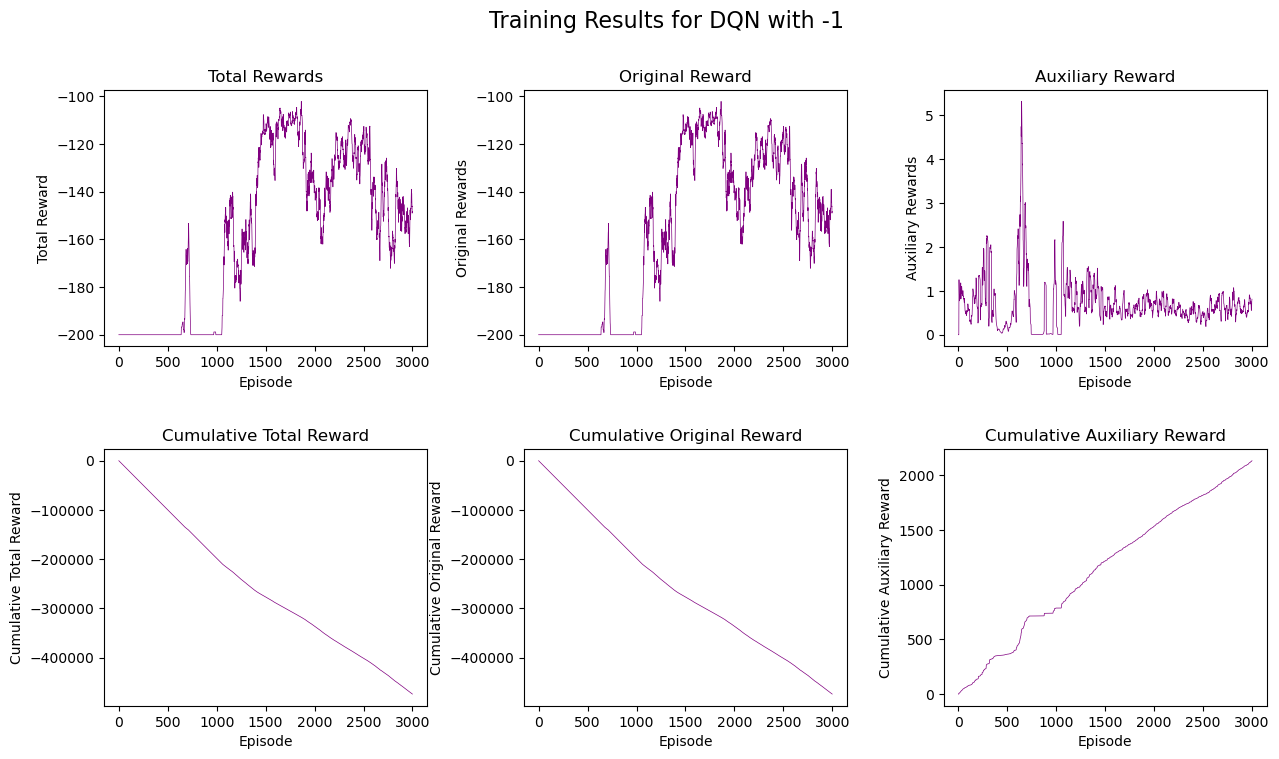

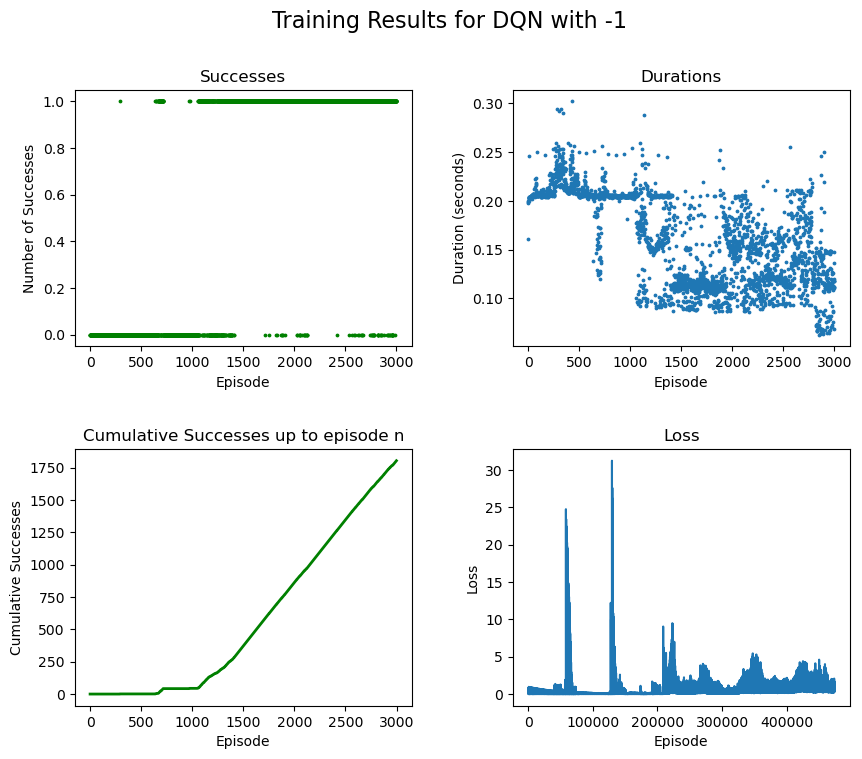

In [46]:
import gymnasium as gym
from DQN import *

# Define your environment here
env = gym.make("MountainCar-v0")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
num_episodes = 3000

agent = DQNAgent(
    env=env,
    state_size=state_size,
    action_size=action_size,
    gamma=0.99,
    min_epsilon=0.05,
    max_epsilon=0.9,
    decay_epsilon=0.995,
    replay_buffer_max=10000,
    batch_size=64,
    learning_rate=0.001,
    hidden_layer_sizes=[64, 64],
    target_update_frequency=1000,
    reward_factor=100
)

# Training the agent
rewards = agent.train(env, agent, num_episodes=num_episodes, rnd = True)
agent.save_agent(f"DQN_{num_episodes}_episodes_rnd")
agent.plots()
agent.reward_plot()
agent.dones_plots()

100%|██████████| 3000/3000 [05:32<00:00,  9.02it/s]


Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_rnd/


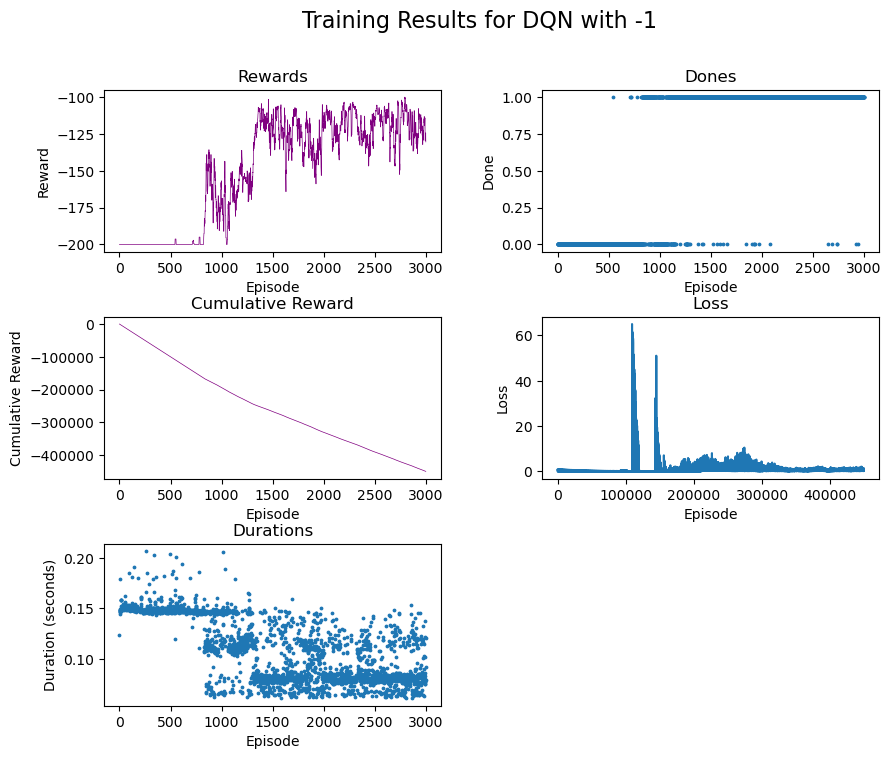

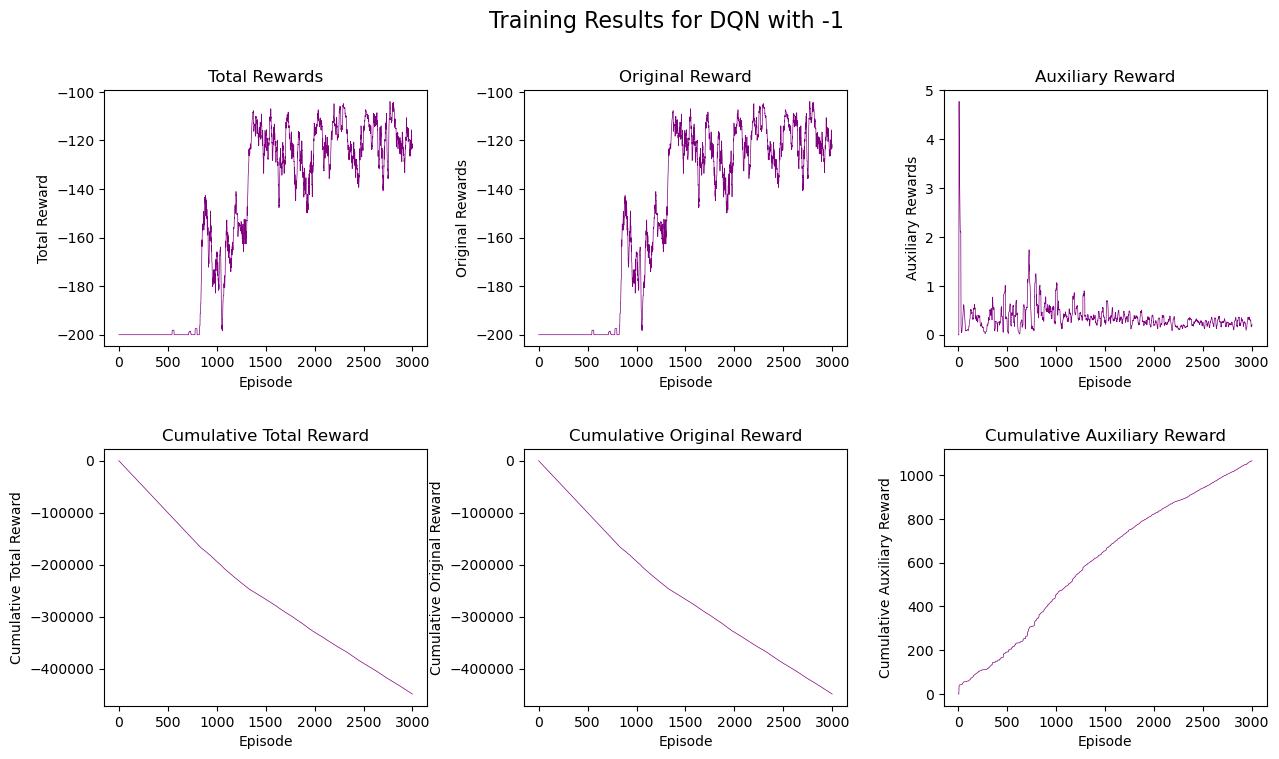

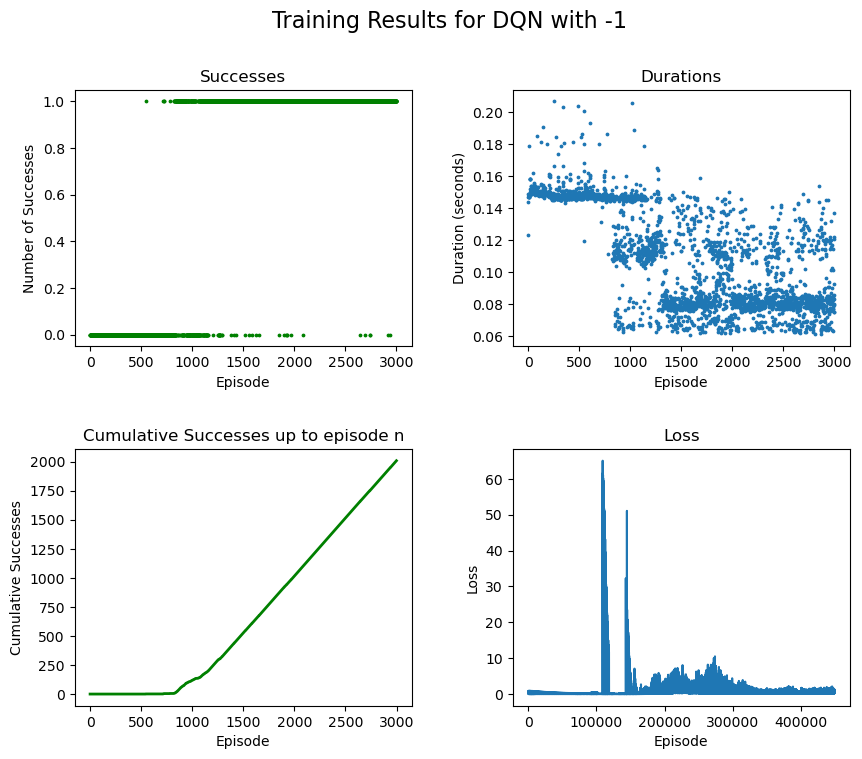

In [48]:
import gymnasium as gym
from DQN import *

# Define your environment here
env = gym.make("MountainCar-v0")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
num_episodes = 3000

agent = DQNAgent(
    env=env,
    state_size=state_size,
    action_size=action_size,
    gamma=0.99,
    min_epsilon=0.05,
    max_epsilon=0.9,
    decay_epsilon=0.995,
    replay_buffer_max=10000,
    batch_size=64,
    learning_rate=0.001,
    hidden_layer_sizes=[64, 64],
    target_update_frequency=1000,
    reward_factor=50
)

# Training the agent
rewards = agent.train(env, agent, num_episodes=num_episodes, rnd = True)
agent.save_agent(f"DQN_{num_episodes}_episodes_rnd")
agent.plots()
agent.reward_plot()
agent.dones_plots()

In [49]:
import gymnasium as gym
from DQN import *

# Define your environment here
env = gym.make("MountainCar-v0")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
num_episodes = 3000

agent = DQNAgent(
    env=env,
    state_size=state_size,
    action_size=action_size,
    gamma=0.99,
    min_epsilon=0.05,
    max_epsilon=0.9,
    decay_epsilon=0.995,
    replay_buffer_max=10000,
    batch_size=64,
    learning_rate=0.001,
    hidden_layer_sizes=[64, 64],
    target_update_frequency=1000,
    reward_factor=150
)

# Training the agent
rewards = agent.train(env, agent, num_episodes=num_episodes, rnd = True)
agent.save_agent(f"DQN_{num_episodes}_episodes_rnd")
agent.plots()
agent.reward_plot()
agent.dones_plots()

 14%|█▍        | 415/3000 [01:03<06:37,  6.51it/s]